In [64]:
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)

In [65]:
base_path = Path("/kaggle/input/d/spikeybarbs/dsc-logika-ui-2025")
base_path.ls()

(#3) [Path('/kaggle/input/d/spikeybarbs/dsc-logika-ui-2025/sample_submission.csv'),Path('/kaggle/input/d/spikeybarbs/dsc-logika-ui-2025/Test'),Path('/kaggle/input/d/spikeybarbs/dsc-logika-ui-2025/Train')]

In [66]:
train_path = base_path/'Train'/'Train'
test_path = base_path/'Test'/'Test'

In [68]:
dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=0.2,
    seed = 42,
    item_tfms=Resize(224),
    batch_tfms=batch_transforms,
    num_workers=4
)

Contoh data training/validasi:
Classes: ['balinese', 'batak', 'dayak', 'javanese', 'minangkabau']
Number of classes: 5
Number of training images: 1402
Number of validation images: 350


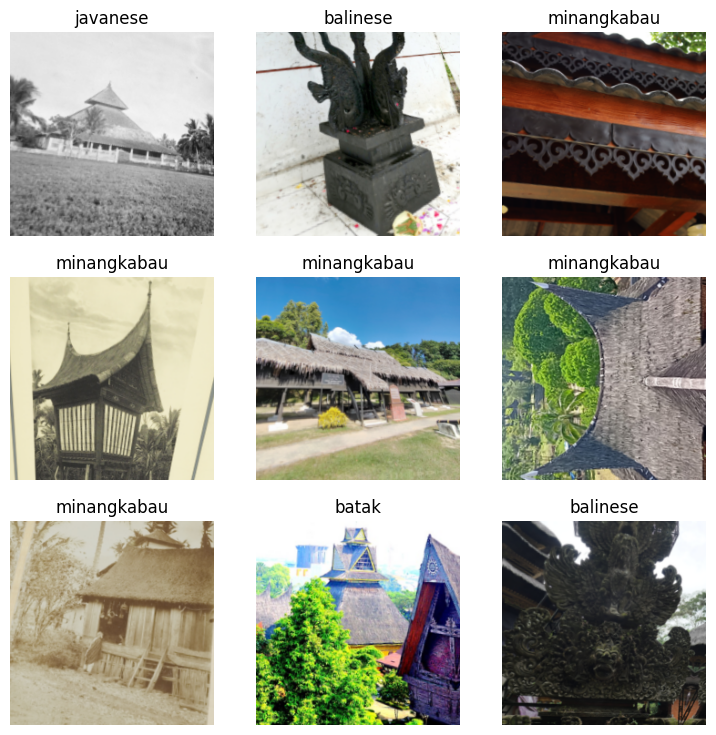

In [69]:
print("Contoh data training/validasi:")
dls.show_batch(max_n=9)

test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files)

print("Classes:", dls.vocab)
print("Number of classes:", len(dls.vocab))
print("Number of training images:", len(dls.train_ds))
print("Number of validation images:", len(dls.valid_ds))

In [70]:
learn = vision_learner(dls, resnet50,
                       metrics=error_rate,
                       path='/kaggle/working/').to_fp16()

AttributeError: 'Sequential' object has no attribute 'plot'

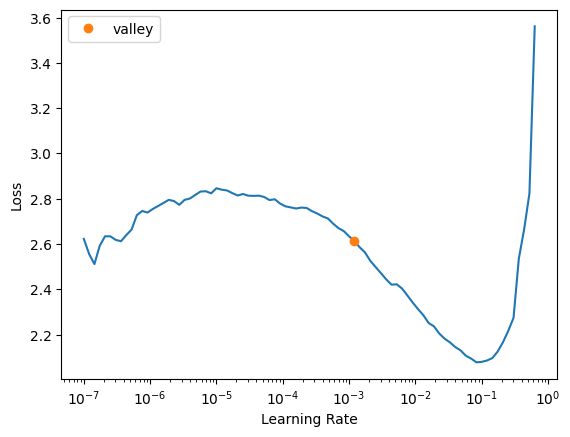

In [72]:
learn.lr_find()

In [73]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(5,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,2.087210,5.469143,0.577143,03:39
1,2.562862,2.893292,0.525714,03:34
2,2.052069,1.435854,0.657143,03:28
3,1.645667,1.263665,0.700000,03:33
4,1.311259,1.101991,0.717143,03:28


In [74]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.730689,1.484961,0.697143,03:29
1,0.675032,2.209685,0.662857,03:38
2,0.613943,0.857558,0.768571,03:28
3,0.535254,0.839770,0.742857,03:29
4,0.450113,0.841630,0.734286,03:33


In [77]:
learn.recorder

Recorder

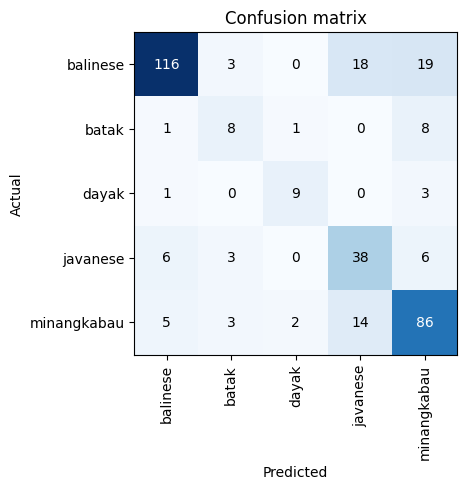

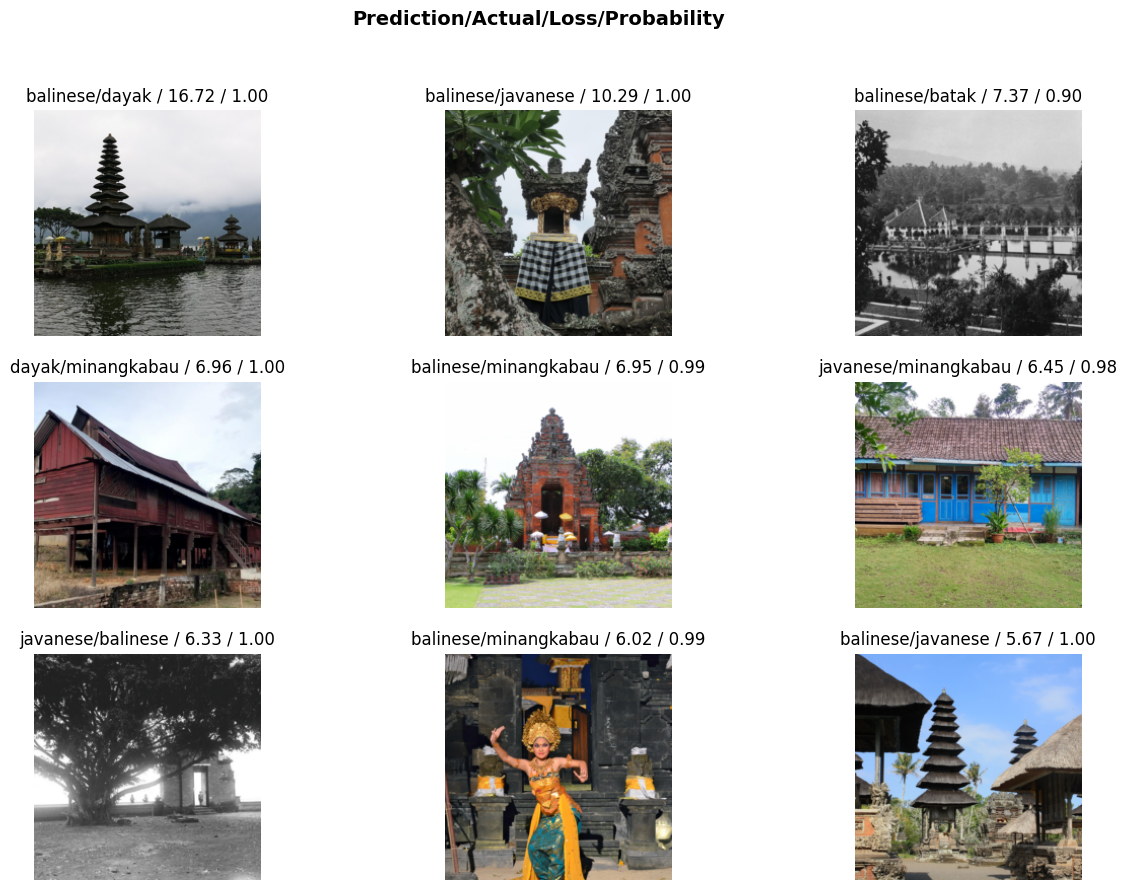

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9, figsize=(15,10))

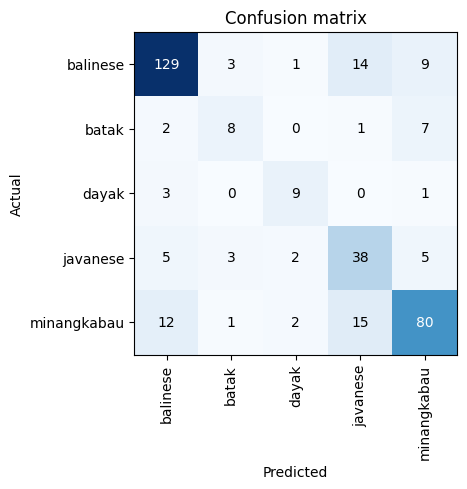

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [79]:
test_files = get_image_files(test_path)

preds, _ = learn.get_preds(dl=dls.test_dl(test_files))
pred_labels = preds.argmax(dim=1)
label_names = [dls.vocab[i] for i in pred_labels]

In [80]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv if needed
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission = submission.set_index('id').loc[sample_sub['id']].reset_index()

In [81]:
submission.sort_values('id', inplace = True)

In [82]:
# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
